# Frozen Lake


## Import libraries and create an environment

In [10]:
import math
import io
from   PIL import Image, ImageDraw, ImageFont
import imageio

import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.colors import Colormap, ListedColormap
import seaborn as sns

import gym                                            # OpenAI Gym library
env = gym.make("FrozenLake-v1")                       # create an environment

## Environment properties

In [12]:
print("space: ", env.observation_space, end=" ")     # observation space
print("count:",  env.observation_space.n)

print("actions", env.action_space, end="  ")         # action space
print("count:",  env.action_space.n)                 # number of actions, type

print('start obs:', env.reset() )                    # initial observation on the system
env.render()

space:  Discrete(16) count: 16
actions Discrete(4)  count: 4
start obs: 0

SFFF
FHFH
FFFH
HFFG


In [ ]:
env.P[2] 

## Actions
**obs** = row * ncols + col;   **start** = 0,  **goal** = 15 (4x4)<br>
**actions**: 0: LEFT,  1: DOWN, 2: RIGHT, 3: UP;
<pre>
<b>S</b>...              3              
.H.H             0 2             
...H              1              
H..<b>G</b>
</pre>
Disable sliding and consider several trajectories on the map. 

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False)  
print("  ", env.reset())
for a in [1,1,2,2,1,2]:
    #print(a, env.step(a))    
    env.render()

   0

SFFF
FHFH
FFFH
HFFG

SFFF
FHFH
FFFH
HFFG

SFFF
FHFH
FFFH
HFFG

SFFF
FHFH
FFFH
HFFG

SFFF
FHFH
FFFH
HFFG

SFFF
FHFH
FFFH
HFFG


## Transition probabilities

In [ ]:
terminals = [5, 7, 11, 12]
for s1 in range(env.observation_space.n):
    if s1 not in terminals:        
        for a1 in range(env.action_space.n):
            print(s1, '<v>^'[a1],end=":")
            for p, s2, r, done in env.P[s1][a1]:        
                print(f" {s2:2d}({p:.2f},{r:.0f},{int(done)})", end="; ")
            print()
        print()

## Visualization

In [4]:
def plt_to_array(fig):
    """ Get array from figure of plt """
    buf = io.BytesIO()
    fig.savefig(buf, format='raw', dpi = 128)
    buf.seek(0)
    arr = np.reshape(np.frombuffer(buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    buf.close()    
    return arr

def add_frame(text):    
    """ Add frame to frames list """
    fig = plt.figure(figsize=(30,20), dpi = 128)    
    plt.rcParams.update({'font.size': 28})
    plt.suptitle(text)
    for i in range(4):                    
        plt.subplot(2, 3, [1,2,4,5][i])
        plt.title (['Q(s,0) <','Q(s,1) v', 'Q(s,2) >', 'Q(s,3) ^'][i]) 
        sns.heatmap(Q[:, i].reshape(4,-1), 
                    annot=True, cbar=False, square=True, vmin=0, vmax=1., cmap="Greys", fmt='.2g',
                    xticklabels=False, yticklabels=False) 
        
    plt.subplot(2, 3, 3)
    plt.title('V(s)')
    sns.heatmap(np.max(Q, axis=1).reshape(4,-1), 
                annot=True, cbar=False, square=True, vmin=0, vmax=1., cmap="Greys", fmt='.2g',
                xticklabels=False, yticklabels=False) 

    plt.subplot(2, 3, 6)
    plt.title('policy')
    p = np.argmax(Q, axis=1)
    sns.heatmap(p.reshape(4,-1), 
                annot=True, cbar=False, square=True, vmin=0, vmax=3., cmap="Greys", fmt='.0f',
                xticklabels=False, yticklabels=False) 
              
              
    frames.append( plt_to_array(fig) )
    plt.close()

## Preparation for training

In [5]:
env = gym.make("FrozenLake-v1", is_slippery=True)  

def policy(s):
    """ epsilon-greedy policy function """            
    #return [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0][s]            
    if np.random.random() < epsilon:
        return np.random.randint(env.action_space.n)
    return np.argmax(Q[s])
          
def test(episodes=1000, ticks=1000):    
    print("\nStart Policy Testing...")     
    steps1, steps2, rews = [], [], []
    for _ in range(episodes):
        s = env.reset()        
        tot = 0
        for t in range(1,ticks+1):
            s, r, done, _ = env.step( policy(s) )                                    
            tot += r
            if done:
                if r:                    
                    steps1.append(t)
                else:
                    steps2.append(t)
                break           
        rews.append(tot)
        if t == ticks and r == 0:
            print("Too long episode")
    steps1 = steps1 or [0]
    steps2 = steps2 or [0]
    print(f"{episodes:4d} rew: {np.mean(rews):5.3f} ± {np.std(rews)/len(rews)**0.5:5.3f} steps ok: {np.mean(steps1):4.1f} ± {np.std(steps1)/len(steps1)**0.5:3.1f}  steps wrong: {np.mean(steps2):4.1f} ± {np.std(steps2)/len(steps2)**0.5:3.1f}" )    

## Q-learning
```
episodes, stat = 10000, 100
reward:      params:
0.74 ± 0.01  {'lm': 0.1, 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 5000}
0.33 ± 0.01  {'lm': 0.1, 'gamma': 1,    'eps1': 1.0, 'eps2': 0.001, 'decays': 1000}
``` 
With `gamma = 1`, the method is unstable. Very sensitive to decays.

In [13]:
def run_episode(ticks=1000):
    tot_rew = 0
    s0 = env.reset()
    for t in range(1,ticks+1):
        a0 = policy(s0)        
        s1, r1, done, _ = env.step(a0)
                
        g = r1 + params['gamma']*np.max(Q[s1]) -  Q[s0, a0]
        Q[s0, a0] +=  params['lm'] * g        
        
        tot_rew += r1
        if done:
            return tot_rew, r1,  t
            
        s0 = s1    
        
    print("Too long episode")
    return tot_rew, 0, t              

## SARSA
```
episodes, stat = 10000, 100
reward:      params:
0.74 ± 0.01  {'lm': 0.1,  'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 5000}
0.18 ± 0.01  {'lm': 0.1,  'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 1000}
0.08 ± 0.01  {'lm': 0.01, 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 5000}
```
With `gamma = 1`, the method is unstable. Very sensitive to `decays`.

In [ ]:
def run_episode(ticks=1000):
    tot_rew = 0
    s0 = env.reset()
    a0 = policy(s0)
    for t in range(ticks):                
        s1, r1, done, _ = env.step(a0)
        a1 = policy(s1)
                
        g = r1 + params['gamma'] * Q[s1, a1] -  Q[s0, a0]
        Q[s0, a0] +=  params['lm'] * g        
        
        tot_rew += r1
        if done:           
            return tot_rew, r1,  t
            
        s0, a0 = s1, a1
        
    print("Too long episode")
    return tot_rew, 0, t              

## Run learning

In [14]:
Q = np.zeros((env.observation_space.n, env.action_space.n))

params = {
    'lm'    : 0.1,      # learning rate
    'gamma' : 0.99,     # discount rate
    'eps1'  : 1.0,      # start epsilon
    'eps2'  : 0.001,    # finish epsilon before 0
    'decays': 5000,     # epochs of decay
}
epsilon = params['eps1']
decay   = math.exp(math.log(params['eps2']/params['eps1'])/params['decays'])

print(params)
oks, steps, rews, history, frames = [], [], [], [], []

episodes, stat = 10000, 100
for episode in range(1,episodes+1):    
    r, ok, t = run_episode()
        
    oks.append(ok)    
    if ok:
        steps.append(t)
    rews.append(r)
    
    epsilon *= decay
    if epsilon < params['eps2']: epsilon = 0.
    
    #if episode in range(100,301) or episode == episodes or episode % 100 == 0:
    #    add_frame(f"episode:{episode:6d}  reward: {np.mean(rews):4.2f} ± {np.std(rews)/len(rews)**0.5:4.2f}  epsilon: {epsilon:.3f}  (c) QuData.com")
    
    if episode % stat == 0 or episode == episodes:
        steps = steps or [0]
        history.append( [episode, np.mean(oks[-stat:]), np.mean(oks[-1000:])] )
        print("\r%5d oks: %4.2f ± %4.2f, steps: %7.1f ± %3.1f, rew: %7.3f ± %5.3f, Q: %4.2f ± %4.2f, eps: %5.3f" 
              % (episode,
                 np.mean(oks[-stat:]),      np.std(oks[-stat:])  /stat  **0.5,
                 np.mean(steps[-stat:]),    np.std(steps[-stat:])/stat**0.5,
                 np.mean(rews[-stat:]),     np.std(rews[-stat:]) /stat **0.5,                                  
                 np.mean(Q[-stat:]),        np.std(Q[-stat:]),
                 epsilon), end="")
            
test()

{'lm': 0.1, 'gamma': 0.99, 'eps1': 1.0, 'eps2': 0.001, 'decays': 5000}
10000 oks: 0.76 ± 0.04, steps:    41.0 ± 2.2, rew:   0.760 ± 0.043, Q: 0.29 ± 0.25, eps: 0.000
Start Policy Testing...
1000 rew: 0.714 ± 0.014 steps ok: 37.6 ± 0.9  steps wrong: 61.8 ± 2.1


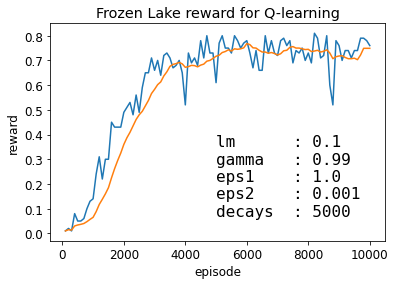

In [16]:
history = np.array(history)
pars = [ f"{k:8s}: {v}\n" for k,v in params.items()]
plt.rcParams.update({'font.size': 12})
plt.title('Frozen Lake reward for Q-learning')
plt.xlabel('episode');  plt.ylabel('reward');
plt.plot(history[:,0], history[:,1])
plt.plot(history[:,0], history[:,2])
plt.text(5000, 0, "".join(pars), {'fontsize':16, 'fontname':'monospace'})
plt.show()

In [ ]:
test(10000)


In [ ]:
imageio.mimwrite("FrozenLake_Q-learning.mp4", frames, fps=10)

In [ ]:
V = np.max(Q, axis=1)
print(V.reshape(4,-1))

pi = np.argmax(Q, axis=1)
print(pi.reshape(4,-1))


In [ ]:
frames = []
plotQ()

## Policy Iteration Algorithm
1. **Policy evaluation**:
$$
V_{k+1}(s) = \sum_{s',r'}  P(s',r'|s,\alpha=\pi(s))\, \bigr[r'+\gamma\,V_k(s')\bigr]
$$
The in-place update assumes one $V(s)$ array, not two. This makes it even faster. We repeat until $V(s)$ stops changing.
2. **Improving the policy**:
$$
\pi(s) = \arg\max_a Q(s,a) =  \arg\max_a \sum_{s',r'} P(s',r'|s,\alpha) \,\bigr[r'+\gamma\,V_k(s')\bigr]
$$
Repeat 1 again.

Сhanged from: https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/0403_Policy_Iteration.html

In [ ]:
def policy_iter(env, gamma, theta):
    """Policy Iteration Algorithm
    
    Params:
        env - environment with following required memebers:
            env.observation_space.n - number of states
            env.action_space.n      - number of actions
            env.P     - prob-transitions and rewards for all states and actions
        gamma (float) - discount factor
        theta (float) - termination condition
    """    
    # 1. Initialization
    V  = np.zeros(env.observation_space.n)
    pi = np.zeros(env.observation_space.n, dtype=int)  # greedy, always pick action 0
    
    while True:
        # 2. Policy Evaluation
        while True:
            delta = 0
            for s in range(env.observation_space.n):
                v = V[s]
                V[s] = sum_sr(env, V=V, s=s, a=pi[s], gamma=gamma)
                delta = max(delta, abs(v - V[s]))
            if delta < theta: break

        # 3. Policy Improvement
        policy_stable = True
        for s in range(env.observation_space.n):
            old_action = pi[s]
            pi[s] = np.argmax([sum_sr(env, V=V, s=s, a=a, gamma=gamma)  # list comprehension
                               for a in range(env.action_space.n)])
            if old_action != pi[s]: policy_stable = False
        if policy_stable: break
    
    return V, pi

def sum_sr(env, V, s, a, gamma):
    """Calc state-action value for state 's' and action 'a'"""
    tmp = 0  # state value for state s
    for p, s_, r, _ in env.P[s][a]:     # see note #1 !
        # p  - transition probability from (s,a) to (s')
        # s_ - next state (s')
        # r  - reward on transition from (s,a) to (s')
        tmp += p * (r + gamma * V[s_])
    return tmp

In [ ]:
V, pi = policy_iter(env, gamma=1, theta=1e-8)
print(V.reshape([4, -1]))
print(pi)